In [1]:
import sys, pdb, os, json
import numpy as np
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

# Add the parent directory to PYTHONPATH so that we can use utils.py
sys.path.append('..')
import utils

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
np.random.seed(1337) #stay 1337 AF

Using TensorFlow backend.


In [2]:
d = 50 #dimensionality of word vectors
data = utils.build_word_vector_matrix('../data/embeddings/5/vectors_d{}.txt'.format(d))
embeddings, labels, id_to_move, move_to_id = data

In [3]:
X_train, y_train, X_test, y_test, _, _ = utils.load_data('../data/test_moves.txt', embeddings, move_to_id)

unknown move Rgxd2
unknown move Rgxh6


In [4]:
# One-hot encoding
uniq_labels = list(move_to_id.values())

In [5]:
def labels_to_ints(labels):
    ints = []
    for label in labels:
        if label in move_to_id:
            ints.append(move_to_id[label])
        else:
            ints.append(-1)
    return ints

y_train = np.asarray(labels_to_ints(y_train))
y_test  = np.asarray(labels_to_ints(y_test))

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1] * X_test.shape[2]))

In [6]:
y_train = to_categorical(y_train, len(uniq_labels))
y_test = to_categorical(y_test, len(uniq_labels))

In [7]:
hyper = {
    'layers': [{
        'units': 512,
        'init': 'normal',
        'activation': 'relu',
        'dropout': 0.5
        },{
        'units': 512,
        'init': 'normal',
        'activation': 'relu',
        'dropout': 0.5

        },{
        'units': len(uniq_labels),
        'init': 'normal',
        'activation': 'softmax'
    }],
    'loss': 'categorical_crossentropy',
    'optimizer': {
        'type': 'sgd',
        'lr': 0.0001
    },
    'metrics': ['accuracy']

}

model_num = 8
model, callbacks = utils.create_model(X_train.shape[1], 
                                      len(uniq_labels), 
                                      save_dir='../data/models/{}'.format(model_num),
                                      hyper=hyper,
                                      verbose=False)
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 512)           5120512     dense_input_1[0][0]              
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 512)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 512)           262656      dropout_1[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 512)           0           dense_2[0][0]                    
___________________________________________________________________________________________

In [8]:
# early stopping
# min_delta = the mininum change in the monitored metric before waiting $patience turns before stopping
# patience = how many consecutive epochs $val_loss change < min_delta before stopping

# callbacks.append(EarlyStopping(monitor='val_loss', 
#                                min_delta=0.001,  
#                                patience=3, 
#                                verbose=1, 
#                                mode='auto'))

In [9]:
history = model.fit(X_train, 
                    y_train, 
                    nb_epoch=10, 
                    validation_data=(X_test, y_test), 
                    callbacks=callbacks,
                    verbose=1)

Train on 9861 samples, validate on 1436 samples
Epoch 1/10
9861/9861 [==============================] - 3s - loss: 9.1075 - acc: 4.0564e-04 - val_loss: 8.3029 - val_acc: 0.0000e+00
Epoch 2/10
9861/9861 [==============================] - 2s - loss: 9.0196 - acc: 1.0141e-04 - val_loss: 8.2790 - val_acc: 0.0000e+00
Epoch 3/10
9861/9861 [==============================] - 2s - loss: 9.0032 - acc: 2.0282e-04 - val_loss: 8.2579 - val_acc: 0.0000e+00
Epoch 4/10
9861/9861 [==============================] - 2s - loss: 8.9421 - acc: 5.0705e-04 - val_loss: 8.2392 - val_acc: 0.0000e+00
Epoch 5/10
9861/9861 [==============================] - 2s - loss: 8.8995 - acc: 6.0846e-04 - val_loss: 8.2226 - val_acc: 6.9638e-04
Epoch 6/10
9861/9861 [==============================] - 2s - loss: 8.8407 - acc: 6.0846e-04 - val_loss: 8.2077 - val_acc: 6.9638e-04
Epoch 7/10
9861/9861 [==============================] - 2s - loss: 8.8216 - acc: 3.0423e-04 - val_loss: 8.1941 - val_acc: 6.9638e-04
Epoch 8/10
9861/9861 

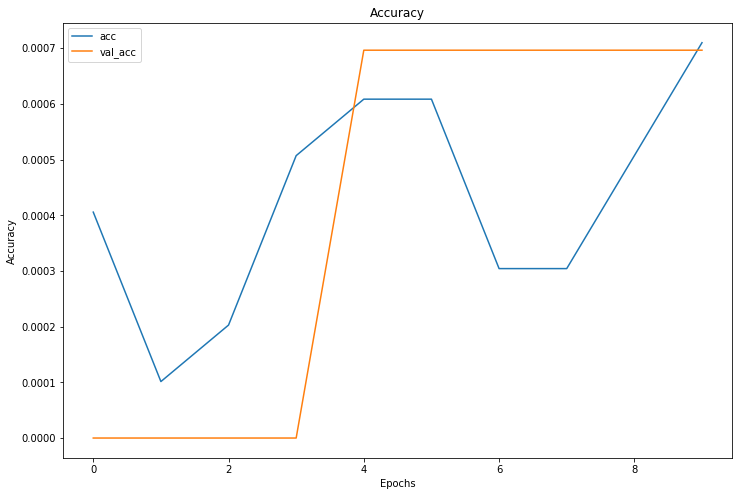

Highest val_acc at epoch 5 with value of 0.001


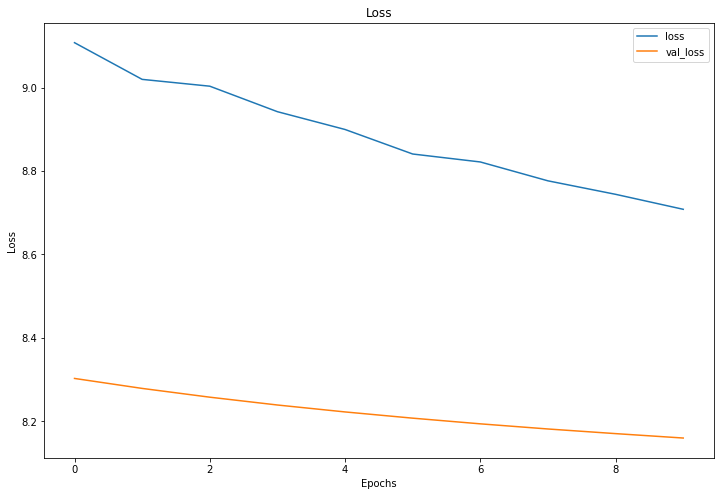

Lowest val_loss at epoch 10 with value of 8.16


In [10]:
utils.plot_model_results(history)